In [237]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import poppy
import astropy.units as u

In [238]:
class SceneFlowDataset(Dataset):
    """ 
    Used to read the Scene Flow dataset for training and testing.
    Returns:
        (img_gt,img_gt_clone,depth_map)
        - img_gt: Ground truth image tensor [C, H, W]
        - img_gt_clone: Clone of the ground truth image tensor [C, H, W], will use later for network input
        - depth_map: Depth map tensor [1, H, W]
    """

    def __init__(self,
                 data_root,
                 dataset_type='train',
                 image_size=256,
                 use_random_crop=False):
        """ 
        Args:
            data_root(str): Root directory of the dataset
            dataset_type(str): 'train' or 'test'
            image_size(int): Size of the cropped images
            use_random_crop(bool): Whether to use random cropping for data augmentation
        """
        super().__init__()
        self.image_size = image_size
        self.use_random_crop = use_random_crop

        # Definite the dataset path
        if dataset_type == 'train':
            self.img_dir = os.path.join(
                data_root, 'FlyingThings3D_subset/train/image_clean/right')
            self.disp_dir = os.path.join(
                data_root, 'FlyingThings3D_subset/train/disparity/right')
        elif dataset_type == 'val':
            self.img_dir = os.path.join(
                data_root, 'FlyingThings3D_subset/val/image_clean/right')
            self.disp_dir = os.path.join(
                data_root, 'FlyingThings3D_subset/val/disparity/right')
        else:
            raise ValueError("dataset_type must be 'train' or 'val'")

        # get all image ID without suffix
        self.file_ids = [
            f[:-4] for f in os.listdir(self.img_dir) if f.endswith('.png')
        ]
        if not self.file_ids:
            raise RuntimeError(f'No image files found in {self.img_dir}')

        # define image transform
        if self.use_random_crop:
            self.transform = transforms.RandomCrop(
                (self.image_size, self.image_size))
        else:
            self.transform = transforms.CenterCrop(
                (self.image_size, self.image_size))

    def __len__(self):
        return len(self.file_ids)

    def __getitem__(self, index):
        """ 
        get and return one data item
        """
        # get file ID
        file_id = self.file_ids[index]

        # load image and depth map
        img_path = os.path.join(self.img_dir, file_id + '.png')
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if image is None:
            raise IOError(f'Failed to load image: {img_path}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255.0  # Convert

        # get the depth map
        disp_path = os.path.join(self.disp_dir, file_id + '.pfm')
        disparity = cv2.imread(disp_path, cv2.IMREAD_UNCHANGED)
        if disparity is None:
            raise IOError(f'Failed to load disparity map: {disp_path}')

        # Ensure the disparity map is in 1-channel format
        if disparity.ndim == 3:
            disparity = disparity[:, :, 0]

        min_dist = 0.2
        max_dist = 20.0

        disp_min = disparity.min()  # minimum disparity
        disp_max = disparity.max()  # maximum disparity

        if disp_max - disp_min < 1e-6:
            depth_meters = np.full_like(disparity, max_dist, dtype=np.float32)
        else:
            disp_norm = (disparity - disp_min) / (disp_max - disp_min)

            min_diopter = 1.0 / max_dist
            max_diopter = 1.0 / min_dist

            current_diopter = min_diopter + disp_norm * (max_diopter -
                                                         min_diopter)
            depth_meters = 1.0 / current_diopter 

        image_tensor = torch.from_numpy(image).permute(2, 0, 1).float()
        depthmap_tensor = torch.from_numpy(depth_meters).float().unsqueeze(0)
        # Apply cropping
        stacked = torch.cat((image_tensor, depthmap_tensor), dim=0)

        try:
            stacked_cropped = self.transform(stacked)
        except ValueError as e:
            print(f'Error during cropping, the file ID is {file_id}: {e}')
            return (torch.zeros(3, self.image_size, self.image_size),
                    torch.zeros(3, self.image_size, self.image_size),
                    torch.zeros(1, self.image_size, self.image_size))

        img_gt = stacked_cropped[0:3, :, :]
        depth_map = stacked_cropped[3:4, :, :]

        return img_gt, img_gt.clone(), depth_map

In [239]:
def calc_defocus_wfe(d_obj, d_focus, f_mm, f_number):
    """Calculate wavefront error due to physical defocus (Meters)"""
    # Handle infinity
    inv_d_obj = 0.0 if d_obj == float('inf') else 1.0 / d_obj
    inv_d_focus = 1.0 / d_focus

    # Diopter difference -> Wavefront error W20
    # W ≈ (f^2 / 8*N^2) * delta_D
    f_m = f_mm * 1e-3
    w_pv = (f_m**2 / (8.0 * f_number**2)) * (inv_d_obj - inv_d_focus)
    return w_pv

def generate_single_psf(d_obj, d_focus, zernike_opt, wavelength, f_mm, f_number, pixel_size, fov_pixels):
    """Generate single wavelength PSF"""
    pupil_diam = (f_mm * u.mm) / f_number

    osys = poppy.OpticalSystem()
    osys.add_pupil(poppy.CircularAperture(radius=pupil_diam/2))

    # --- Combine phases ---
    # 1. Physical defocus (Focus Term)
    w_defocus = calc_defocus_wfe(d_obj, d_focus, f_mm, f_number)

    # 2. EDoF optimization term (Zernike Term)
    # Copy coefficient table to avoid polluting original dictionary
    coeffs = zernike_opt.copy() if zernike_opt else {}

    # Superimpose physical defocus onto Z4 (Defocus)
    # Note: poppy coefficients are amplitudes, can be directly superimposed
    coeffs[4] = coeffs.get(4, 0.0) + w_defocus

    # Convert to list for Poppy
    max_idx = max(coeffs.keys()) if coeffs else 4
    c_list = [0.0] * max(max_idx, 4)
    for k, v in coeffs.items():
        if k > 0: c_list[k-1] = v

    osys.add_pupil(poppy.ZernikeWFE(coefficients=c_list, radius=pupil_diam/2))

    # --- Detector settings (Physical -> Angular) ---
    # 25mm lens: FOV corresponding to 3.45um pixel
    pixel_scale = (pixel_size * u.m / (f_mm * u.mm)).to(u.arcsec, equivalencies=u.dimensionless_angles())
    osys.add_detector(pixelscale=pixel_scale/u.pixel, fov_pixels=fov_pixels)

    # Calculate
    psf = osys.calc_psf(wavelength=wavelength, display_intermediates=False)
    return psf[0].data

def generate_rgb_psf_tensor(d_obj, d_focus, zernike_opt, **kwargs):
    """Generate RGB 3-channel PSF Tensor [3, H, W]"""
    # Typical wavelengths
    waves = [630e-9, 550e-9, 470e-9] # R, G, B
    channels = []

    for w in waves:
        psf = generate_single_psf(d_obj, d_focus, zernike_opt, wavelength=w, **kwargs)
        channels.append(psf)
    psf_rgb = np.stack(channels, axis=0)  # [3, H, W]
    
    channel_sums = psf_rgb.sum(axis=(1,2), keepdims=True)
    psf_rgb /= channel_sums  # Normalize each channel
    psf_tensor = torch.from_numpy(psf_rgb).float()
    return psf_tensor

In [240]:
def get_layer_masks(depth_map_meters, num_layers=12, min_dist=0.2, max_dist=20.0):
    """
    Convert physical depth map to K layer Masks (based on uniform diopter slicing)
    depth_map_meters: [B, 1, H, W]
    Returns: layers_alpha [B, K, 1, H, W]
    """
    device = depth_map_meters.device
    
    # 1. Convert to diopter (1/d)
    diopter_map = 1.0 / (depth_map_meters + 1e-8)
    max_diopter = 1.0 / min_dist # 5.0
    min_diopter = 1.0 / max_dist # 0.05
    
    # 2. Normalize diopter to [0, K]
    # 0 represents farthest (20m), K represents nearest (0.2m)
    norm_diopter = (diopter_map - min_diopter) / (max_diopter - min_diopter)
    scaled_diopter = norm_diopter * num_layers
    
    # 3. Generate Mask for each layer
    # layer_indices: [1, K, 1, 1, 1]
    layer_indices = torch.arange(num_layers, device=device).view(1, num_layers, 1, 1, 1)
    
    # Compare: which layer the pixel belongs to
    # diff: [B, K, 1, H, W]
    diff = scaled_diopter.unsqueeze(1) - layer_indices
    
    # Hard Mask: Select interval [0, 1)
    mask = (diff >= 0) & (diff < 1)
    
    # Flip order! Ensure k=0 is nearest (foreground), k=N is farthest (background), or vice versa
    # The logic here is 0 corresponds to farthest.
    # To match "near occludes far" compositing logic, usually expect index 0 to be foreground.
    # So we flip it:
    return torch.flip(mask.float(), dims=[1])

In [241]:
import torch.nn.functional as F

def render_blurred_image(sharp_img, layer_masks, psf_bank):
    """
    Use Back-to-Front (far to near) blending strategy to simulate occlusion.
    
    sharp_img: [B, 3, H, W]
    layer_masks: [B, K, 1, H, W] (Order: 0=Foreground/Nearest, K-1=Background/Farthest)
    psf_bank: [K, 3, H_k, W_k] (PSF corresponding to each layer)
    """
    B, K, _, H, W = layer_masks.shape
    device = sharp_img.device
    
    # Initialize Canvas
    canvas = torch.zeros_like(sharp_img)
    
    # Draw from the farthest layer (Background) to the nearest layer (Foreground)
    # So near objects will cover far objects (Alpha Blending)
    # Index K-1 is farthest, 0 is nearest
    
    for k in range(K - 1, -1, -1):
        # 1. Get current layer data
        mask = layer_masks[:, k] # [B, 1, H, W]
        psf = psf_bank[k]        # [3, H_k, W_k]
        
        # 2. Premultiply Alpha (RGB * Mask)
        # This step extracts the content of the current layer, background is black
        masked_rgb = sharp_img * mask
        
        # 3. Convolution (Blur)
        pad_h = psf.shape[1] // 2
        pad_w = psf.shape[2] // 2
        
        psf_weight = psf.unsqueeze(1) # [3, 1, H, W]
        
        # 3.1 Blur Color (Premultiplied Alpha)
        blur_rgb = F.conv2d(masked_rgb, psf_weight, padding=(pad_h, pad_w), groups=3)
        
        # 3.2 Blur Alpha (Calculate occlusion weight)
        # Mask after PSF blur represents the coverage of the object on the screen (including defocus edges)
        # Expand Mask to 3 channels to match RGB convolution (if PSF 3 channels are different)
        mask_expanded = mask.repeat(1, 3, 1, 1)
        blur_alpha = F.conv2d(mask_expanded, psf_weight, padding=(pad_h, pad_w), groups=3)
        
        # Crop to match original size (handle size increase due to even PSF size)
        if blur_rgb.shape[-2:] != (H, W):
            blur_rgb = blur_rgb[..., :H, :W]
            blur_alpha = blur_alpha[..., :H, :W]
        
        # Clamp Alpha between [0, 1] (prevent numerical errors)
        blur_alpha = torch.clamp(blur_alpha, 0.0, 1.0)
        
        # 4. Compositing (Over Operator)
        # New_Canvas = Current_Layer + Old_Canvas * (1 - Current_Layer_Alpha)
        # Because it is Back-to-Front, current layer (k) is closer than previously drawn layers (k+1...K-1)
        # So current layer will occlude the previous canvas
        canvas = blur_rgb + canvas * (1.0 - blur_alpha)
        
    return canvas

In [242]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define near and far focus distances
d_near = 1.5  # Near focus distance: 0.5m
d_far = 4.0   # Far focus distance: 5.0m

# Optical system parameters
f_mm = 25.0
f_number = 4
pixel_size = 3.45e-6
fov_pixels = 64

# Layer settings
num_layers = 12
min_dist = 0.2
max_dist = 20.0

# Define Zernike coefficients (Optional, set to None if EDoF optimization is not needed)
zernike_coeffs = None  # Or use optimized coefficients

def generate_psf_bank(d_focus, num_layers, min_dist, max_dist, **kwargs):
    """Generate PSF Bank for each layer [K, 3, H, W]"""
    psf_list = []
    
    min_diopter = 1.0 / max_dist
    max_diopter = 1.0 / min_dist
    
    print(f"Generating PSF Bank (Focus={d_focus}m)...")
    
    for k in range(num_layers):
        # Calculate center object distance for this layer
        # get_layer_masks returns order [Foreground(Near) -> Background(Far)]
        # Original diopter mapping is [Far -> Near]
        # So we need to reverse index to match get_layer_masks output order
        
        # k=0 corresponds to Bank[0], should be nearest layer (High Diopter)
        # In original slicing, High Diopter corresponds to index = num_layers - 1
        k_orig = num_layers - 1 - k
        
        # Calculate normalized value in original slicing (0~1)
        norm_val = (k_orig + 0.5) / num_layers
        
        diopter = min_diopter + norm_val * (max_diopter - min_diopter)
        d_obj = 1.0 / diopter
        
        psf = generate_rgb_psf_tensor(
            d_obj=d_obj,
            d_focus=d_focus,
            **kwargs
        )
        psf_list.append(psf)
        
    return torch.stack(psf_list).to(device)

# Generate two Banks
psf_bank_near = generate_psf_bank(
    d_focus=d_near,
    num_layers=num_layers,
    min_dist=min_dist,
    max_dist=max_dist,
    zernike_opt=zernike_coeffs,
    f_mm=f_mm,
    f_number=f_number,
    pixel_size=pixel_size,
    fov_pixels=fov_pixels
)

psf_bank_far = generate_psf_bank(
    d_focus=d_far,
    num_layers=num_layers,
    min_dist=min_dist,
    max_dist=max_dist,
    zernike_opt=zernike_coeffs,
    f_mm=f_mm,
    f_number=f_number,
    pixel_size=pixel_size,
    fov_pixels=fov_pixels
)

print(f"PSF Bank Shape: {psf_bank_near.shape}")

Using device: cuda
Generating PSF Bank (Focus=1.5m)...
Generating PSF Bank (Focus=4.0m)...
Generating PSF Bank (Focus=4.0m)...
PSF Bank Shape: torch.Size([12, 3, 128, 128])
PSF Bank Shape: torch.Size([12, 3, 128, 128])


In [243]:
# Use render_blurred_image for layered rendering

# 1. Load data


if 'img_gt_batch' in dir() and img_gt_batch is not None:
    test_image = img_gt_batch.to(device)
    if 'depth_map_batch' in dir():
        test_depth = depth_map_batch.to(device)
    else:
        test_image = None
else:
    test_image = None

if test_image is None:
    # Create dataset and data loader
    if 'train_loader' not in dir():
        data_root = '/home/LionelZ/Datasets' 
        train_dataset = SceneFlowDataset(
            data_root=data_root,
            dataset_type='train',
            image_size=512,
            use_random_crop=True
        )
        train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    
    test_image, _, test_depth = next(iter(train_loader))
    test_image = test_image.to(device)
    test_depth = test_depth.to(device)

print(f"Test image shape: {test_image.shape}")
print(f"Test depth map shape: {test_depth.shape}")

# 2. Calculate Layer Masks
# get_layer_masks returns [B, K, 1, H, W], order is Foreground -> Background
layer_masks = get_layer_masks(test_depth, num_layers=num_layers, min_dist=min_dist, max_dist=max_dist)
print(f"Layer Masks Shape: {layer_masks.shape}")

# 3. Render near focus image
print("\nRendering near focus image (Focus at 0.5m)...")
# render_blurred_image requires psf_bank [K, 3, H, W]
img_blurred_near = render_blurred_image(test_image, layer_masks, psf_bank_near)
print(f"Near blurred image shape: {img_blurred_near.shape}")

# 4. Render far focus image
print("\nRendering far focus image (Focus at 5.0m)...")
img_blurred_far = render_blurred_image(test_image, layer_masks, psf_bank_far)
print(f"Far blurred image shape: {img_blurred_far.shape}")

Test image shape: torch.Size([1, 3, 256, 256])
Test depth map shape: torch.Size([1, 1, 256, 256])
Layer Masks Shape: torch.Size([1, 12, 1, 256, 256])

Rendering near focus image (Focus at 0.5m)...
Near blurred image shape: torch.Size([1, 3, 256, 256])

Rendering far focus image (Focus at 5.0m)...
Far blurred image shape: torch.Size([1, 3, 256, 256])



Comparison plot saved as: near_far_focus_comparison_layered.png


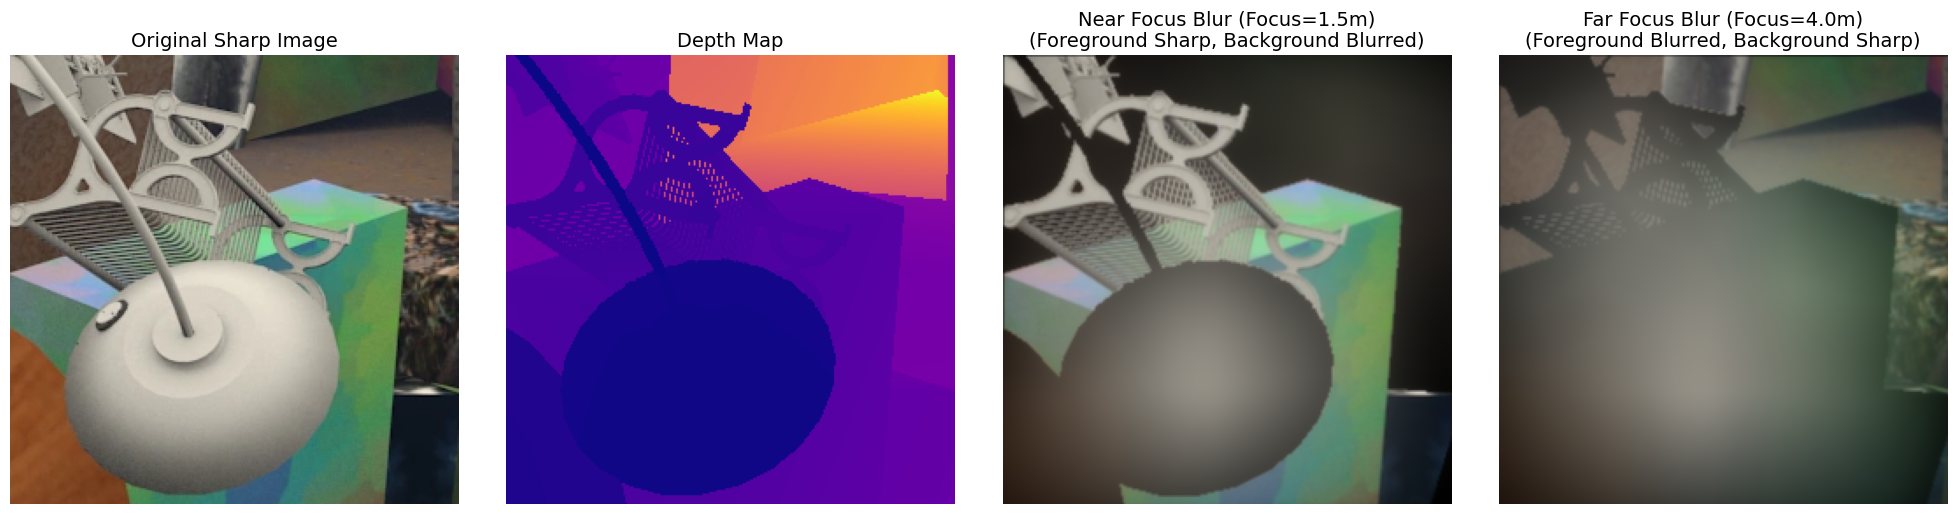

In [244]:
# Visualization comparison: Original, Near Blur, Far Blur

from turtle import color


def tensor_to_image(tensor):
    """Convert tensor to displayable numpy array"""
    img = tensor.cpu().detach().squeeze(0).permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    return img

# Create comparison plot
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Original sharp image
axes[0].imshow(tensor_to_image(test_image))
axes[0].set_title('Original Sharp Image', fontsize=14)
axes[0].axis('off')

# Depth map
depth_vis = test_depth.cpu().detach().squeeze().numpy()
axes[1].imshow(depth_vis, cmap='plasma')
axes[1].set_title('Depth Map', fontsize=14)
axes[1].axis('off')

# Near blurred image
axes[2].imshow(tensor_to_image(img_blurred_near))
axes[2].set_title(f'Near Focus Blur (Focus={d_near}m)\n(Foreground Sharp, Background Blurred)', fontsize=14)
axes[2].axis('off')

# Far blurred image
axes[3].imshow(tensor_to_image(img_blurred_far))
axes[3].set_title(f'Far Focus Blur (Focus={d_far}m)\n(Foreground Blurred, Background Sharp)', fontsize=14)
axes[3].axis('off')

plt.tight_layout()
plt.savefig('near_far_focus_comparison_layered.png', dpi=150, bbox_inches='tight')
print("\nComparison plot saved as: near_far_focus_comparison_layered.png")
plt.show()

PSF Bank sample plot saved as: psf_bank_samples.png


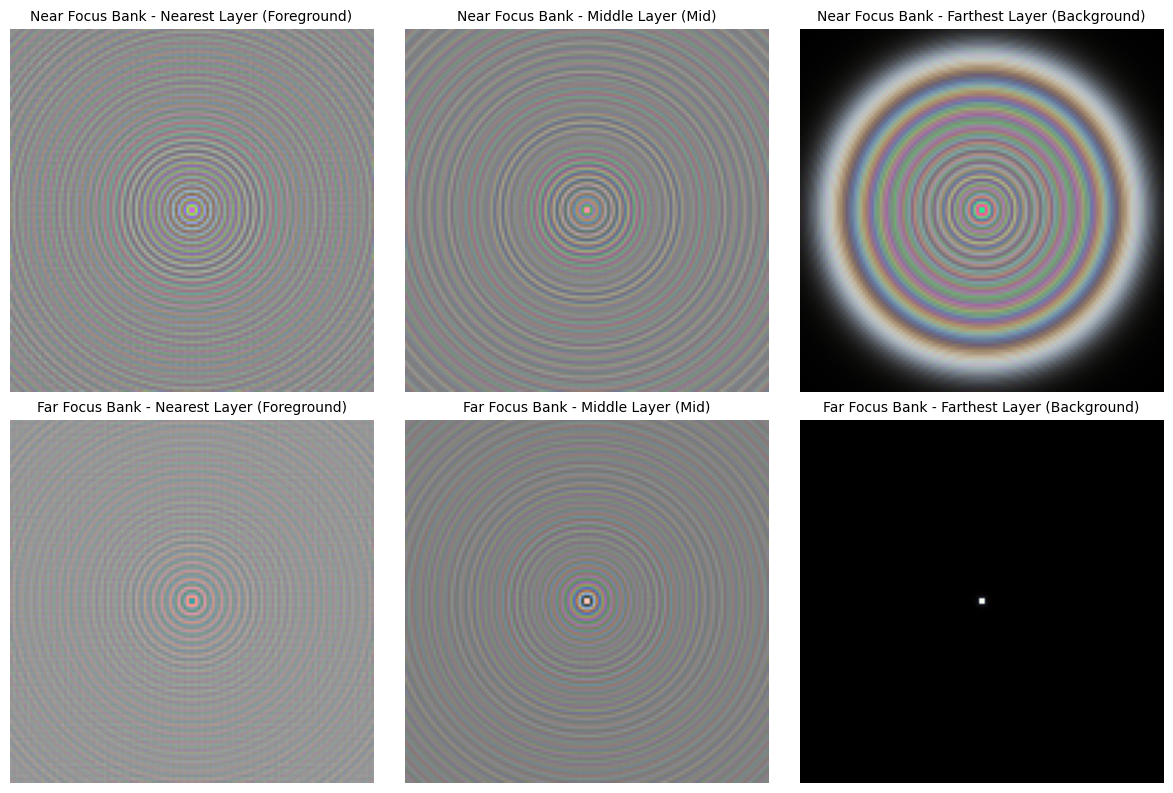

In [245]:
# Visualize samples from PSF Bank (Nearest, Middle, Farthest)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Select indices: 0 (Nearest), K//2 (Middle), K-1 (Farthest)
indices = [0, num_layers//2, num_layers-1]
labels = ['Nearest Layer (Foreground)', 'Middle Layer (Mid)', 'Farthest Layer (Background)']

# Near Focus Bank
for i, idx in enumerate(indices):
    psf = psf_bank_near[idx].cpu().numpy().transpose(1, 2, 0) # [H, W, 3]
    # Normalize for display
    psf_disp = psf / psf.max()
    axes[0, i].imshow(psf_disp)
    axes[0, i].set_title(f'Near Focus Bank - {labels[i]}', fontsize=10)
    axes[0, i].axis('off')

# Far Focus Bank
for i, idx in enumerate(indices):
    psf = psf_bank_far[idx].cpu().numpy().transpose(1, 2, 0)
    psf_disp = psf / psf.max()
    axes[1, i].imshow(psf_disp)
    axes[1, i].set_title(f'Far Focus Bank - {labels[i]}', fontsize=10)
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig('psf_bank_samples.png', dpi=150, bbox_inches='tight')
print("PSF Bank sample plot saved as: psf_bank_samples.png")
plt.show()